# Spiral classification

Adapted from Alfredo Canziani and Yann LeCun NYU material  
See original: https://github.com/Atcold/pytorch-Deep-Learning/blob/master/04-spiral_classification.ipynb

We want to learn to separate some non-linear data

In [1]:
import random
import torch
from torch import nn
import math
from matplotlib import pyplot as plt
from plot_lib import plot_data, plot_model, set_default
import wandb
seed = 0
random.seed(seed)
torch.manual_seed(seed)
set_default()

In [2]:
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes

X = torch.zeros(N * C, D)
y = torch.zeros(N * C, dtype=torch.long)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.25
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


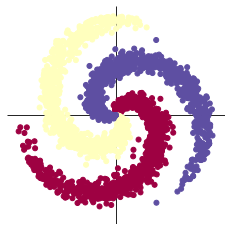

In [3]:
plot_data(X, y)

## Linear model

In [4]:
wandb.init(project='spiral_classification')

wandb: Currently logged in as: ingambe (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
learning_rate = 1e-3
lambda_l2 = 1e-5

def init_weights(m):
    torch.nn.init.xavier_normal_(m.weight)
    torch.nn.init.constant_(m.bias, 0)
    return m

model = nn.Sequential(
    init_weights(nn.Linear(D, C))
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

In [6]:
nb_epochs = 1000
# Training
for t in range(nb_epochs):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    wandb.log({
        'linear/loss': loss.item(),
        'linear/accuracy': acc,
    })
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

Our linear model can't fit the dataset, the accuracy stays low even after a high number of iterations

This is because we are only able to define **hyperplanes**

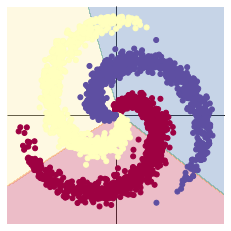

In [7]:
plot_model(X, y, model)

## Multi Layers Perceptrons

In [8]:
learning_rate = 1e-2
lambda_l2 = 1e-5

def init_weights(m):
    torch.nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('tanh'))
    torch.nn.init.constant_(m.bias, 0)
    return m

model = nn.Sequential(
    init_weights(nn.Linear(D, 8)),
    nn.Tanh(),
    init_weights(nn.Linear(8, C))
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

In [9]:
nb_epochs = 1000
# Training
for t in range(nb_epochs):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    wandb.log({
        'mlp/loss': loss.item(),
        'mlp/accuracy': acc,
    })
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

Our accuracy has been vastly improved and we can clearly see that the model better fit the dataset

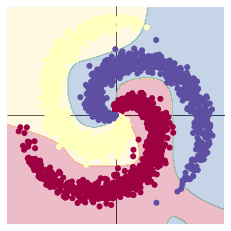

In [10]:
plot_model(X, y, model)